In [2]:
import tensorflow as tf
import numpy as np
import util
import matplotlib.pyplot as plt
import math

# MNIST

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

X = mnist.train._images.reshape(55000, 28, 28, 1)
Y = mnist.train._labels
index = np.arange(55000)
np.random.shuffle(index)

th = 50000

X_labeled = util.BatchFeeder(X[index[:th]], Y[index[:th]], 128)
X_unlabeled = util.BatchFeeder(X[index[th:]], Y[index[th:]], 128)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# ADGM

In [36]:
class ADGM:
    def __init__(self):
        tf.reset_default_graph()
        
        #Building the model
        self.built = False
        self.sesh = tf.Session()
        self.e = 0
        
        # Tracking data
        self.learning_curve = []
        
        # Parameters
        self.num_classes = 10
        self.batch_size = 128
        self.latent_size = 128
        self.hidden_size = 256
        self.supervised_scaling_const = 0.1 * (55000 / 100)
        self.learning_rate = 0.001
        self.outputs = {}
        self._losses = {}
        
        # Building the graph
        self.ops = self.build()
        self.sesh.run(tf.global_variables_initializer())
        
    def build(self):
        # Placeholders for input and dropout probs.
        if self.built:
            return -1
        else:
            self.built = True
            
        # Input Data X
        self.x_labeled = tf.placeholder(tf.float32, shape=[self.batch_size, 28, 28, 1])
        self.x_unlabeled = tf.placeholder(tf.float32, shape=[self.batch_size, 28, 28, 1])
        self.x = tf.concat([self.x_labeled, self.x_unlabeled], 0)
        self.x_unlabeled_tiled = tf.tile(self.x_unlabeled, [self.num_classes, 1, 1, 1])
        
        # Input Data Y
        self.y_labeled = tf.placeholder(tf.float32, shape=[self.batch_size, self.num_classes])
        self.y, self.y_unlabeled = self.generate_y(self.y_labeled)
        
        self.outputs = {'labeled': {'x_in': self.x_labeled}, 'unlabeled': {'x_in': self.x_unlabeled_tiled}}
        
        # Building the Q networks
        q_x = self.encoder(self.x)
        q_a_x = self.gaussian_stochastic(q_x, self.latent_size, 'q_a')
        q_y_ax_input = self.linear_deterministic([(q_a_x, 'q_a_inter_1'), (q_x, 'q_x_inter_1')])
        _ = self.multinomial_stochastic(q_y_ax_input, self.num_classes, 'q_y')
        q_z_axy_input = self.linear_deterministic([(q_a_x, 'q_a_inter'), (q_x, 'q_x_inter'), (self.y, 'y_inter')])
        q_z_axy = self.gaussian_stochastic(q_z_axy_input, self.latent_size, 'q_z')
        
        # Building the P networks
        p_a_yz_input = self.linear_deterministic([(self.y, 'y_inter_2'), (q_z_axy, 'q_z_axy_inter')])
        p_a_yz = self.gaussian_stochastic(p_a_yz_input, self.latent_size, 'p_a')
        p_x_input = self.linear_deterministic([(p_a_yz, 'p_a_yz'), (q_z_axy, 'q_z_axy'), (self.y, 'q_y_ax')])
        p_x = self.decoder(p_x_input)
        x_hat = self.gaussian_stochastic(p_x, 1, 'p_x')
        
        # Get the elbo term to minimize
        elbo = self.add_losses()
                
        # Defining optimization procedure.
        with tf.name_scope("Adam_optimizer"):
            optimizer = tf.train.AdamOptimizer(self.learning_rate)
            tvars = tf.trainable_variables()
            grads_and_vars = optimizer.compute_gradients(elbo, tvars)
            clipped = [(tf.clip_by_value(grad, -5, 5), tvar) for grad, tvar in grads_and_vars]
            train = optimizer.apply_gradients(clipped, name="minimize_cost")
        
        return dict(
            train=train,
            elbo=elbo,
            xl=self.x_labeled,
            xul=self.x_unlabeled,
            yl=self.y_labeled,
            xhat = x_hat
        )
        
        
    # encoder network
    def encoder(self, _input):
        with tf.variable_scope('encoder'):
            fn = tf.nn.elu
            filtersize = (5,5)
            
            # layer 1
            n_filt = 64 
            layer1 = tf.layers.conv2d(_input, n_filt, filtersize, strides=(2,2), padding="same", activation=None)
            #layer1 = tf.contrib.layers.batch_norm(layer1, is_training=bn)
            layer1 = fn(layer1)
            
            # layer 2
            n_filt = 128 
            layer2 = tf.layers.conv2d(layer1, n_filt, filtersize, strides=(2,2), padding="same", activation=None)
            #layer2 = tf.contrib.layers.batch_norm(layer2, is_training=bn)
            layer2 = fn(layer2)
            
            # layer 3
            n_filt = 256 
            layer3 = tf.layers.conv2d(layer2, n_filt, filtersize, strides=(2,2), padding="same", activation=None)
            #layer3 = tf.contrib.layers.batch_norm(layer3, is_training=bn)
            layer3 = fn(layer3)
            
            # getting the features
            x_features_all = tf.reduce_mean(layer3, axis=[1, 2]) #Global average pooling happens here.
            x_features_labeled, x_features_unlabeled = tf.split(x_features_all, 2)

        x_features_tiled = tf.tile(x_features_unlabeled, [self.num_classes, 1])
        x_features = tf.concat([x_features_labeled, x_features_tiled], 0)
        return x_features
    
    # decoder network
    def decoder(self, p_x):
        with tf.variable_scope('decoder'):
            fn = tf.nn.relu
            filtersize = (5,5)
            
            # Maping from latenet to some dimension with fully connected layer.
            _input = tf.reshape(p_x, (self.batch_size*(self.num_classes+1), self.latent_size))
            net = tf.contrib.slim.fully_connected(_input, 1024, activation_fn=None)
            #net = tf.contrib.layers.batch_norm(net, is_training=bn)
            net = tf.nn.relu(net)
            net = tf.contrib.slim.fully_connected(net, 7*7*128) 
            #net = tf.contrib.layers.batch_norm(net, is_training=bn)
            
            net = tf.reshape(net, [-1, 7, 7, 128])
            
            # layer 1 (outputs: 512x4x4x4)
            n_filt = 64 
            layer1 = tf.layers.conv2d_transpose(net, n_filt, filtersize, strides=(2,2), padding="same", activation=None)
            #layer1 = tf.contrib.layers.batch_norm(layer1, is_training=bn)
            layer1 = fn(layer1)
            
            # layer 2 (outputs: 256x8x8x8)
            n_filt = 1 
            layer2 = tf.layers.conv2d_transpose(layer1, n_filt, filtersize, strides=(2,2), padding="same", activation=None)
            #layer2 = tf.contrib.layers.batch_norm(layer2, is_training=bn)
            layer2 = fn(layer2)
        return layer2
    
    # test
    def gaussian_stochastic(self, input_tensor, num_maps, scope):
        with tf.variable_scope(scope):
            input_tensor = tf.expand_dims(tf.expand_dims(input_tensor, 1), 1) if len(input_tensor.get_shape()) != 4 \
                else input_tensor
                
            # For some reasons there is additional layer here.
            # Conv layer is used to model dense layer for speed up
            intermediate = tf.contrib.slim.conv2d(input_tensor, self.hidden_size, [1, 1], scope='conv1')
            
            # MEAN of Gaussian
            mean = tf.contrib.slim.conv2d(intermediate,
                                          num_maps, 
                                          [1, 1], 
                                          activation_fn=None, 
                                          scope='mean')
            # SIGMA**2 for Gaussian range (0 --> inf)
            sigma2 = tf.nn.softplus(
                                tf.contrib.slim.conv2d(intermediate,
                                num_maps,
                                [1, 1],
                                activation_fn=None,
                                scope='sigma2'))
            # DRAW samples
            rv_single_draw = mean + tf.sqrt(sigma2) * tf.random_normal(tf.shape(mean))

        # Record outputs with appropriate keys.
        self.split_labeled_unlabeled(mean, '{}_mu'.format(scope))
        self.split_labeled_unlabeled(sigma2, '{}_sigma2'.format(scope))
        self.split_labeled_unlabeled(rv_single_draw, '{}_sample'.format(scope))
        return rv_single_draw
    
    # Stochastic output for multinomial distribution
    def multinomial_stochastic(self, input_tensor, num_maps, scope):
        with tf.variable_scope(scope):
            input_tensor = tf.expand_dims(tf.expand_dims(input_tensor, 1), 1) if len(input_tensor.get_shape()) != 4 \
                else input_tensor
                
            # For some reasons there is additional layer here.
            # Conv layer is used to model dense layer for speed up
            intermediate = tf.contrib.slim.conv2d(input_tensor, 
                                       self.hidden_size, 
                                       [1, 1], 
                                       scope='conv1')
            # I need to figure out what Pi is.
            pi = tf.contrib.slim.conv2d(intermediate,
                                        num_maps, 
                                        [1, 1], 
                                        activation_fn=None, 
                                        scope='mean')
            
            rv_single_draw = tf.nn.softmax(pi)
            
        self.split_labeled_unlabeled(pi, '{}_pi'.format(scope))
        self.split_labeled_unlabeled(rv_single_draw, '{}_sample'.format(scope))
        return rv_single_draw

    # linear deterministic
    def linear_deterministic(self, inputs_list_with_scopes):
        with tf.variable_scope('linear'):
            outputs_list = list()
            for tensor, scope in inputs_list_with_scopes:
                tensor = tf.expand_dims(tf.expand_dims(tensor, 1), 1) if len(tensor.get_shape()) != 4 else tensor
                linear_layer = tf.contrib.slim.conv2d(tensor, self.latent_size, [1, 1], scope=scope)
                outputs_list.append(linear_layer)
            return sum(outputs_list)
        
    # Calculate elbo for both labeled and unlabeled data.
    def add_losses(self):
        # Losses
        lb_l = self._calc_lb('labeled')
        self._losses['lb_l'] = tf.reduce_mean(lb_l)
        lb_u = self._calc_lb('unlabeled')
        self._losses['lb_u'] = tf.reduce_mean(lb_u)
        elbo = tf.reduce_mean(lb_l) + tf.reduce_mean(lb_u)
        self._losses['lb'] = elbo
        return elbo
    
    # Calculates Elbo for labeled and unlabeled data.
    def _calc_lb(self, data_type):

        # Go over these with the paper.
        outputs = self.outputs[data_type]
        log_qa = self.gaussian_log_density(outputs['q_a_sample'], outputs['q_a_mu'], outputs['q_a_sigma2'])
        log_qz = self.gaussian_log_density(outputs['q_z_sample'], outputs['q_z_mu'], outputs['q_z_sigma2'])
        log_pz = self.standard_gaussian_log_density(outputs['q_z_sample'])
        log_pa = self.gaussian_log_density(outputs['q_a_sample'], outputs['p_a_mu'], outputs['p_a_sigma2'])
        # We are assuming gaussian output here.
        log_px = self.gaussian_log_density(outputs['x_in'], outputs['p_x_mu'], outputs['p_x_sigma2'])

        self._losses['{}_log_qa'.format(data_type)] = tf.reduce_mean(log_qa)
        self._losses['{}_log_qz'.format(data_type)] = tf.reduce_mean(log_qz)
        self._losses['{}_log_pz'.format(data_type)] = tf.reduce_mean(log_pz)
        self._losses['{}_log_pa'.format(data_type)] = tf.reduce_mean(log_pa)
        self._losses['{}_log_px'.format(data_type)] = tf.reduce_mean(log_px)
        
        if data_type == 'labeled':
            temp = tf.expand_dims(tf.expand_dims(self.y_labeled, axis=1),axis=1)
            log_py = self.standard_multinomial_log_density(temp, self.num_classes)
            lb_sum = tf.squeeze(log_py) + log_pz + log_pa + log_px - log_qa - log_qz
            
            log_qy = self.multinomial_log_density(outputs['q_y_sample'], self.y_labeled)
            lb = lb_sum - self.supervised_scaling_const * log_qy
            tf.summary.scalar('labeled_log_qy', tf.reduce_sum(log_qy))
            
        else:  
            temp = tf.expand_dims(tf.expand_dims(self.y_unlabeled, axis=1),axis=1)
            log_py = self.standard_multinomial_log_density(temp, self.num_classes)
            lb_sum = tf.squeeze(log_py) + log_pz + log_pa + log_px - log_qa - log_qz
            
            lb_sum = tf.transpose(tf.reshape(lb_sum, [self.num_classes, self.batch_size]))
            qy = tf.slice(tf.squeeze(outputs['q_y_sample']), [0, 0], [self.batch_size, 10])
            qy += 1e-8
            qy /= tf.reduce_sum(qy, axis=1, keep_dims=True)
            lb = tf.reduce_sum(qy * (tf.reshape(lb_sum, tf.shape(qy)) - tf.log(qy)), axis=1)
            
        tf.summary.scalar('{}_log_qa'.format(data_type), tf.reduce_sum(log_qa))
        tf.summary.scalar('{}_log_qz'.format(data_type), tf.reduce_sum(log_qz))
        tf.summary.scalar('{}_log_pz'.format(data_type), tf.reduce_sum(log_pz))
        tf.summary.scalar('{}_log_pa'.format(data_type), tf.reduce_sum(log_pa))
        tf.summary.scalar('{}_log_py'.format(data_type), tf.reduce_sum(log_py))
        tf.summary.scalar('{}_log_px'.format(data_type), tf.reduce_sum(log_px))

        return lb
        
    # Creates a tensor of size batchsize*numclasses by numclasses.
    # All possible labelings to marginalize over for unlabeled data.
    def generate_y(self, y_labeled):
        y_unlabeled_tiled = tf.reshape(tf.tile(tf.eye(self.num_classes), [1, self.batch_size]),
                                       [self.num_classes * self.batch_size, self.num_classes])
        y_all = tf.concat([y_labeled, y_unlabeled_tiled], 0)
        return y_all, y_unlabeled_tiled
    
    # Split
    def split_labeled_unlabeled(self, tensor, key):
        if tensor.get_shape()[0] % (self.num_classes + 1) == 0:
            _all = tf.split(tensor, self.num_classes + 1)
            self.outputs['labeled'][key] = _all[0]
            self.outputs['unlabeled'][key] = tf.concat(_all[1:], 0)
        else:
            self.outputs['labeled'][key], self.outputs['unlabeled'][key] = tf.split(tensor, 2)
        
    @staticmethod
    def standard_gaussian_log_density(x):
        c = - 0.5 * math.log(2 * math.pi)
        density = c - tf.square(x) / 2
        return -tf.reduce_mean(tf.reduce_sum(density, axis=-1), axis=[1, 2])
    
    @staticmethod
    def standard_multinomial_log_density(x, num_classes):
        total = tf.stack([tf.shape(x)[0] * tf.shape(x)[3]])
        labels = tf.reshape(tf.tile(tf.constant([1 / num_classes]), total), tf.shape(x))
        density = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=x)
        return tf.reduce_sum(density, axis=-1)

    @staticmethod
    def gaussian_log_density(x, mu, sigma2):
        c = - 0.5 * math.log(2 * math.pi)
        density = c - tf.log(sigma2) / 2 - tf.squared_difference(x, mu) / (2 * sigma2)
        return -tf.reduce_mean(tf.reduce_sum(density, axis=-1), axis=(1, 2))

    @staticmethod
    def multinomial_log_density(x, mu):
        density = tf.nn.softmax_cross_entropy_with_logits(labels=mu, logits=x)
        return tf.reduce_sum(density, axis=-1)

    @staticmethod
    def define_initializer():
        initializer = tf.truncated_normal_initializer(mean=0.0, stddev=0.01)
        return initializer
    
    # training procedure.
    def train(self, X_labeled, X_unlabeled, epochs, valid=None):
        # Making the saver object.
        e = 0
        log = []
        xhats = []
        while e < epochs:
            #Training happens here.
            xl, yl = X_labeled.next()
            xul, _ = X_unlabeled.next()
            
            feed_dict = {self.ops["xl"]: xl,
                         self.ops["xul"]: xul,
                         self.ops["yl"]: yl}
            ops_to_run = [self.ops["elbo"],
                          self.ops["train"],
                          self.ops["xhat"]
                         ]
            elbo, _, xhat = self.sesh.run(ops_to_run, feed_dict)
            log.append(elbo)
            xhats.append(xhat)
            self.e+=1
            e+= 1
        return log, xhats

In [37]:
m = ADGM()

In [38]:
output = m.train(X_labeled, X_unlabeled, 1000)

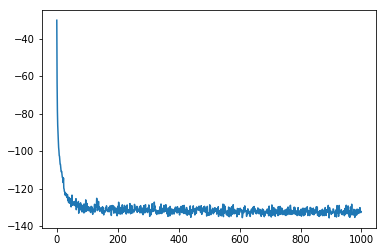

In [39]:
plt.figure()
plt.plot(log)
plt.show()

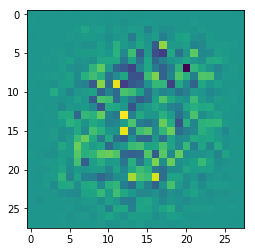

In [51]:
plt.figure()
plt.imshow(output[1][-1][0][:, :, 0])
plt.show()